In [62]:
from digit_dataset import *
from digit_model import *
from label_model import *
from segmentation import *
from utils import *

from matplotlib import pyplot as plt

In [63]:
device = select_device()

Using MPS


In [64]:
digit_m = load_model(device, "../data/mnist_cnn.pt")

label_m = Label_Model(device, digit_m, Label_Model_Args())

segmentation_m = Segmentation_Model(label_m)

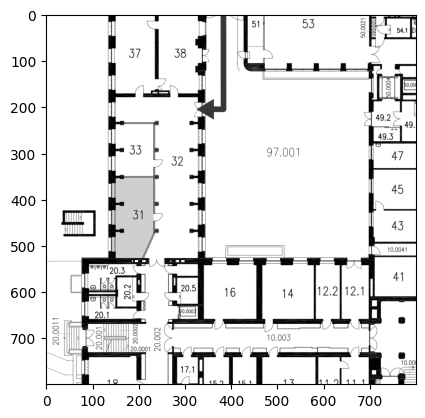

In [65]:
img = segmentation_m.load_image("../data/cab_floor_0.png")

plt.imshow(img[200:1000, 200:1000], cmap='gray')

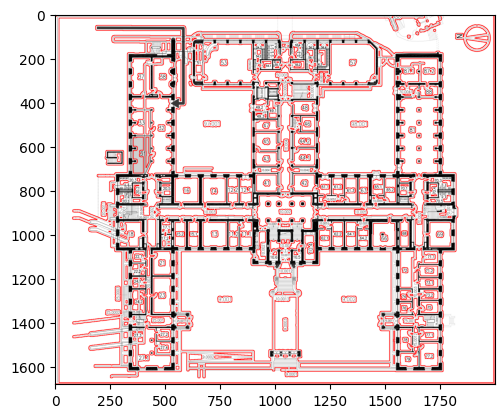

In [160]:
contours, hierarchy = segmentation_m.extract_room_contours(img)

contour_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
segmentation_m.draw(contour_img, [("", c) for c in contours])

plt.imshow(contour_img, cmap='gray')

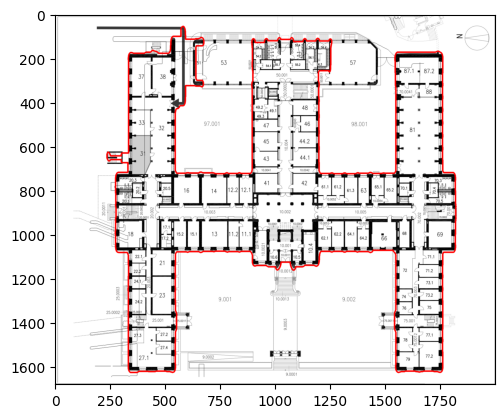

In [279]:
kernel1 = 31

dilation_shape = cv2.MORPH_RECT
dilatation_size = 21
element = cv2.getStructuringElement(dilation_shape, (2 * dilatation_size + 1, 2 * dilatation_size + 1),(dilatation_size, dilatation_size))
    
thr = cv2.threshold(cv2.GaussianBlur(img, (kernel1,kernel2), 0), 180, 255, cv2.THRESH_BINARY_INV)[1]
thr = cv2.dilate(thr, element)

mask = np.zeros((img.shape[0]+2,img.shape[1]+2), dtype=np.uint8)
cv2.floodFill(thr,mask,[0,0], [-1])
mask = cv2.dilate(mask, element)

contours_building, hierarchy = cv2.findContours(mask, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

building_contour = sorted(contours_building, key=len)[-1]

img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_color, [building_contour], 0, [255,0,0], 5)

plt.imshow(img_color)

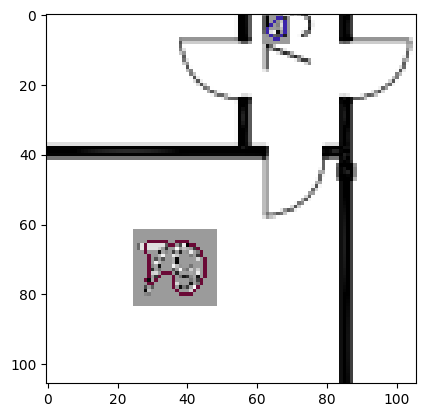

In [159]:
contour = [contour for i,contour in enumerate(contours) if hierarchy[0, i, 2]!=-1][4]
x,y,w,h = cv2.boundingRect(contour)
patch = img[y:y+h,x:x+h]

cv2.drawContours(patch, [contour], 0, [0.0,0.0,0.0], 1)

kernel = 13
thr = cv2.threshold(cv2.GaussianBlur(patch, (kernel, kernel), 0), 50, 255, cv2.THRESH_OTSU)[1]
text_contours, _ = cv2.findContours(thr, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

patch_color = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)

for label_contour in text_contours:
    (x2, y2, w2, h2) = cv2.boundingRect(label_contour)
    label_patch = patch[y2:y2 + h2, x2:x2 + h2]
    if (w2/w)>0.7 or (h2/h)>0.7:
        continue

    b = int(0.2*w2)

    patch_color[y2-b:y2+h2+b, x2-b:x2+w2+b] -= 100
    
    cv2.drawContours(patch_color, [label_contour], -1, [np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)])
                 
plt.imshow(patch_color, cmap='gray')

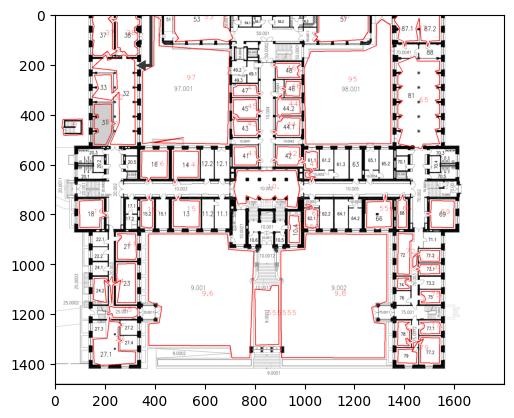

In [104]:
patches = []

rooms = segmentation_m.extract_rooms(img, contours, hierarchy, patches)

room_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
segmentation_m.draw(room_img, rooms)
plt.imshow(room_img[200:2000, 200:2000])

In [68]:
patch_num = 0

digits= 2
(28, 28) float32
0.0 0.9886563
(28, 28) float32
0.0 0.9886563


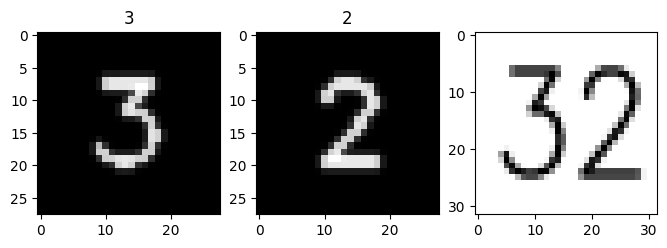

In [103]:
label_m.args.digit_thr = 0.3
label_m.args.pad = 1.0
label_m.args.min_confidence_ratio = 1



patch = patches[39]
images = label_m.split(patch)
print("digits=", len(images))
fig, axes = plt.subplots(1, len(images)+1, figsize=(8,8))

for i in range(len(images)):
    image = label_m.canonicalize_digit(images[i]) 
    
    print(image.shape, image.dtype)
    print(image.min(), image.max())

    axes[i].title.set_text(str(label_m.predict_digit(image))) 
    axes[i].imshow(image, cmap='gray')

axes[len(images)].imshow(patch, cmap='gray')

In [70]:
patch_num += 1
patch_num

1

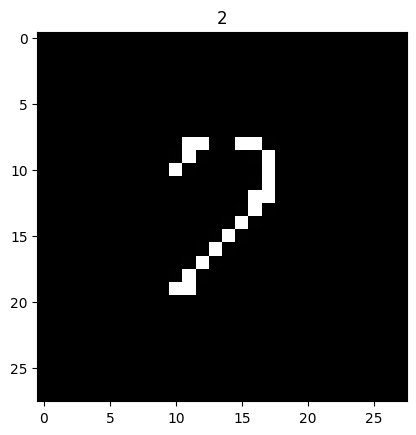

In [280]:
digit = images[1]

pad = 1.0
thr = 0.6

(h,w) = digit.shape
digit = np.pad(digit, int(pad*w))
digit = cv2.resize(digit, (28,28), interpolation=cv2.INTER_LINEAR)
digit = digit.astype(np.float32) / 255.

mask = digit > thr
digit[~mask] = 0
digit[mask] = 1
digit = cv2.GaussianBlur(digit,(3,3),0.3)

plt.title(label_m.predict_digit(digit))
plt.imshow(digit, cmap='gray')

0.0 0.74509925


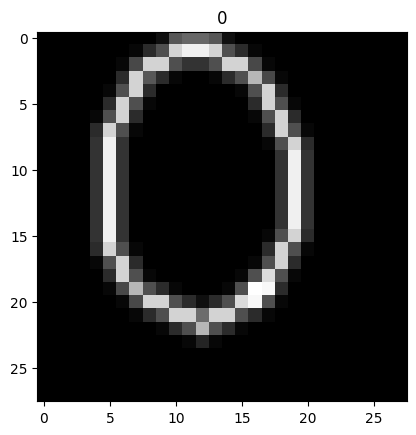

In [282]:
dataset = CustomDigitDataset(100)
digit = dataset[29][0].reshape((28,28))
print(digit.min(), digit.max())
plt.title(label_m.predict_digit(digit))
plt.imshow(digit, cmap='gray')